In [1]:
import numpy as np
np.random.seed(2016)

import os
import glob
import cv2
import math
import pickle
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#import statistics

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.metrics import log_loss
from scipy.misc import imread, imresize
from sklearn.metrics import accuracy_score

%matplotlib inline
use_cache = 1
# color type: 1 - grey, 3 - rgb
color_type_global = 1
# color_type = 1 - gray
# color_type = 3 - RGB

Using Theano backend.


In [2]:
import sys
print(sys.path)
#sys.path.append('C:\\opencv\x08uild\\python\x02.7d')

#import cv2

['', 'C:\\Users\\Vibhav\\Anaconda2\\lib\\site-packages\\keras-1.0.2-py2.7.egg', 'C:\\Users\\Vibhav\\Anaconda2\\python27.zip', 'C:\\Users\\Vibhav\\Anaconda2\\DLLs', 'C:\\Users\\Vibhav\\Anaconda2\\lib', 'C:\\Users\\Vibhav\\Anaconda2\\lib\\plat-win', 'C:\\Users\\Vibhav\\Anaconda2\\lib\\lib-tk', 'C:\\Users\\Vibhav\\Anaconda2', 'c:\\users\\vibhav\\anaconda2\\lib\\site-packages\\sphinx-1.3.5-py2.7.egg', 'c:\\users\\vibhav\\anaconda2\\lib\\site-packages\\setuptools-20.2.2-py2.7.egg', 'C:\\Users\\Vibhav\\Anaconda2\\lib\\site-packages', 'C:\\Users\\Vibhav\\Anaconda2\\lib\\site-packages\\cryptography-1.0.2-py2.7-win-amd64.egg', 'C:\\Users\\Vibhav\\Anaconda2\\lib\\site-packages\\win32', 'C:\\Users\\Vibhav\\Anaconda2\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Vibhav\\Anaconda2\\lib\\site-packages\\Pythonwin', 'C:\\Users\\Vibhav\\Anaconda2\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Vibhav\\.ipython']


In [3]:
def get_im_skipy(path, img_rows, img_cols, color_type=1):
    # Load as grayscale
    if color_type == 1:
        img = imread(path, True)
    elif color_type == 3:
        img = imread(path)
    # Reduce size
    resized = imresize(img, (img_cols, img_rows))
    return resized


def get_im_cv2(path, img_rows, img_cols, color_type=1):
    # Load as grayscale
    if color_type == 1:
        img = cv2.imread(path, 0)
    elif color_type == 3:
        img = cv2.imread(path)
    # Reduce size
    resized = cv2.resize(img, (img_cols, img_rows))
    return resized
def get_driver_data():
    dr = dict()
    path = os.path.join( 'input', 'driver_imgs_list.csv')
    print('Read drivers data')
    f = open(path, 'r')
    line = f.readline()
    while (1):
        line = f.readline()
        if line == '':
            break
        arr = line.strip().split(',')
        dr[arr[2]] = arr[0]
    f.close()
    return dr

Folder c0
input\train\c0\img_100026.jpg
input\train\c0\img_10003.jpg
Folder c1
input\train\c1\img_100021.jpg
input\train\c1\img_100045.jpg
Folder c2
input\train\c2\img_100029.jpg
input\train\c2\img_100108.jpg
Folder c3
input\train\c3\img_100006.jpg
input\train\c3\img_100041.jpg
Folder c4
input\train\c4\img_100225.jpg
input\train\c4\img_10025.jpg
Folder c5
input\train\c5\img_10000.jpg
input\train\c5\img_100027.jpg
Folder c6
input\train\c6\img_0.jpg
input\train\c6\img_100036.jpg
Folder c7
input\train\c7\img_100057.jpg
input\train\c7\img_100076.jpg
Folder c8
input\train\c8\img_100015.jpg
input\train\c8\img_100235.jpg
Folder c9
input\train\c9\img_100090.jpg
input\train\c9\img_100100.jpg


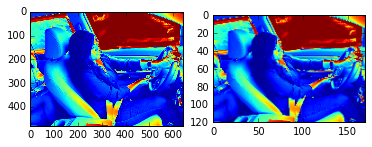

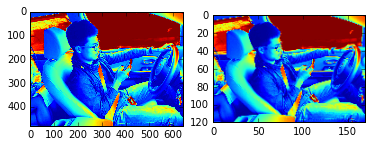

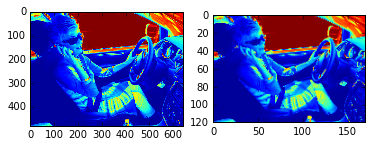

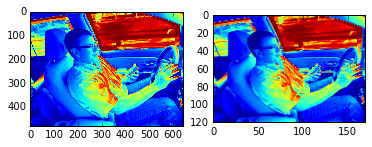

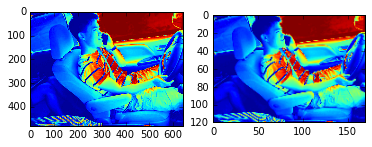

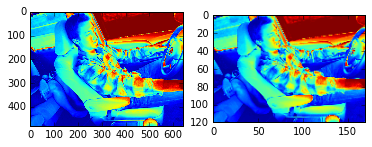

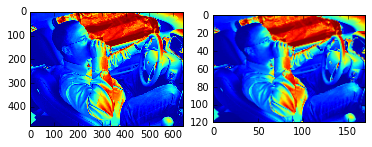

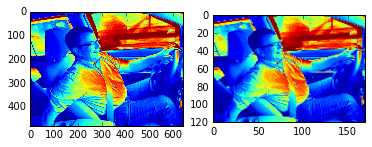

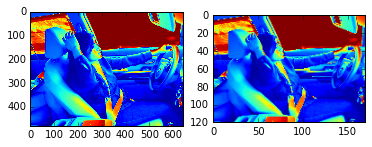

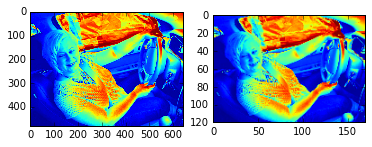

In [4]:
cnt = 0
for j in range(10):
    print('Folder c{}'.format(j))
                            
    path1 = os.path.join('input','train','c'+str(j),'*.jpg')
    files = glob.glob(path1)
    for fl in files:
        
        if cnt < 2:
            print fl
            fig = plt.figure(j)
            img_full = cv2.imread(fl, 0)
            img_sm = cv2.resize(img_full, (170, 120))
            ax1 = plt.subplot(1, 2, 1)
            ax2 = plt.subplot(1, 2, 2)
            ax1.imshow(img_full)
            ax2.imshow(img_sm)
            cnt += 1
        else:
            
            break;
    cnt=0

In [5]:
def load_train(img_rows, img_cols, color_type=1):
    X_train = []
    y_train = []
    driver_id = []

    driver_data = get_driver_data()

    print('Read train images')
    for j in range(10):
        print('Load folder c{}'.format(j))
        path = os.path.join( 'input', 'train', 'c' + str(j), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = get_im_cv2(fl, img_rows, img_cols, color_type)
            X_train.append(img)
            y_train.append(j)
            driver_id.append(driver_data[flbase])

    unique_drivers = sorted(list(set(driver_id)))
    print('Unique drivers: {}'.format(len(unique_drivers)))
    print(unique_drivers)
    return X_train, y_train, driver_id, unique_drivers


def load_test(img_rows, img_cols, color_type=1):
    print('Read test images')
    path = os.path.join( 'input', 'test', '*.jpg')
    files = glob.glob(path)
    X_test = []
    X_test_id = []
    total = 0
    thr = math.floor(len(files)/10)
    for fl in files:
        flbase = os.path.basename(fl)
        img = get_im_cv2(fl, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(flbase)
        total += 1
        if total%thr == 0:
            print('Read {} images from {}'.format(total, len(files)))

    return X_test, X_test_id


def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()
    else:
        print('Directory doesnt exists')


def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data


def save_model(model):
    json_string = model.to_json()
    if not os.path.isdir('cache'):
        os.mkdir('cache')
    open(os.path.join('cache', 'architecture.json'), 'w').write(json_string)
    model.save_weights(os.path.join('cache', 'model_weights.h5'), overwrite=True)


def read_model():
    model = model_from_json(open(os.path.join('cache', 'architecture.json')).read())
    model.load_weights(os.path.join('cache', 'model_weights.h5'))
    return model

In [6]:
def split_validation_set(train, target, test_size):
    random_state = 51
    X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test


def create_submission(predictions, test_id, info):
    result1 = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result1.loc[:, 'img'] = pd.Series(test_id, index=result1.index)
    now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'submission_' + suffix + '.csv')
    result1.to_csv(sub_file, index=False)

In [7]:
def read_and_normalize_train_data(img_rows, img_cols, color_type=1):
    cache_path = os.path.join('cache', 'train_r_' + str(img_rows) + '_c_' + str(img_cols) + '_t_' + str(color_type) + '.dat')
    if not os.path.isfile(cache_path) or use_cache == 0:
        train_data, train_target, driver_id, unique_drivers = load_train(img_rows, img_cols, color_type)
        cache_data((train_data, train_target, driver_id, unique_drivers), cache_path)
    else:
        print('Restore train from cache!')
        (train_data, train_target, driver_id, unique_drivers) = restore_data(cache_path)

    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)
    train_data = train_data.reshape(train_data.shape[0], color_type, img_rows, img_cols)
    train_target = np_utils.to_categorical(train_target, 10)
    train_data = train_data.astype('float32')
    train_data /= 255
    print('Train shape:', train_data.shape)
    print(train_data.shape[0], 'train samples')
    return train_data, train_target, driver_id, unique_drivers


def read_and_normalize_test_data(img_rows, img_cols, color_type=1):
    cache_path = os.path.join('cache', 'test_r_' + str(img_rows) + '_c_' + str(img_cols) + '_t_' + str(color_type) + '.dat')
    if not os.path.isfile(cache_path) or use_cache == 0:
        test_data, test_id = load_test(img_rows, img_cols, color_type)
        cache_data((test_data, test_id), cache_path)
    else:
        print('Restore test from cache!')
        (test_data, test_id) = restore_data(cache_path)

    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(test_data.shape[0], color_type, img_rows, img_cols)
    test_data = test_data.astype('float32')
    test_data /= 255
    print('Test shape:', test_data.shape)
    print(test_data.shape[0], 'test samples')
    return test_data, test_id

In [8]:
def dict_to_list(d):
    ret = []
    for i in d.items():
        ret.append(i[1])
    return ret


def merge_several_folds_mean(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a += np.array(data[i])
    a /= nfolds
    return a.tolist()


def merge_several_folds_geom(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a *= np.array(data[i])
    a = np.power(a, 1/nfolds)
    return a.tolist()


def copy_selected_drivers(train_data, train_target, driver_id, driver_list):
    data = []
    target = []
    index = []
    for i in range(len(driver_id)):
        if driver_id[i] in driver_list:
            data.append(train_data[i])
            target.append(train_target[i])
            index.append(i)
    data = np.array(data, dtype=np.float32)
    target = np.array(target, dtype=np.float32)
    index = np.array(index, dtype=np.uint32)
    return data, target, index

In [16]:
def create_model_v1(img_rows, img_cols, color_type=1):
    nb_classes = 10
    # number of convolutional filters to use
    nb_filters = 8
    # size of pooling area for max pooling
    nb_pool = 2
    # convolution kernel size
    nb_conv = 2
    model = Sequential()
    model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                            border_mode='valid',
                            input_shape=(color_type, img_rows, img_cols)))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))

    #sgd = SGD(lr=0.1, decay=0, momentum=0, nesterov=False)
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])
    
    return model

In [10]:
def run_single():
    # input image dimensions
    img_rows, img_cols = 72, 102
    batch_size = 32
    nb_epoch = 2
    random_state = 51

    train_data, train_target, driver_id, unique_drivers = read_and_normalize_train_data(img_rows, img_cols, color_type_global)
    test_data, test_id = read_and_normalize_test_data(img_rows, img_cols, color_type_global)

    yfull_train = dict()
    yfull_test = []
    unique_list_train = ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024',
                     'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049',
                     'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072']
    X_train, Y_train, train_index = copy_selected_drivers(train_data, train_target, driver_id, unique_list_train)
    unique_list_valid = ['p075','p081']
    X_valid, Y_valid, test_index = copy_selected_drivers(train_data, train_target, driver_id, unique_list_valid)

    print('Start Single Run')
    print('Split train: ', len(X_train), len(Y_train))
    print('Split valid: ', len(X_valid), len(Y_valid))
    print('Train drivers: ', unique_list_train)
    print('Test drivers: ', unique_list_valid)

    model = create_model_v1(img_rows, img_cols, color_type_global)
    model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
               verbose=1, validation_data=(X_valid, Y_valid))

    # score = model.evaluate(X_valid, Y_valid, show_accuracy=True, verbose=0)
    # print('Score log_loss: ', score[0])

    predictions_valid = model.predict(X_valid, batch_size=128, verbose=1)
    score = log_loss(Y_valid, predictions_valid)
    print('Score log_loss: ', score)
    
    # Store valid predictions
    for i in range(len(test_index)):
        yfull_train[test_index[i]] = predictions_valid[i]

    # Store test predictions
    test_prediction = model.predict(test_data, batch_size=128, verbose=1)
    yfull_test.append(test_prediction)

    print('Final log_loss: {}, rows: {} cols: {} epoch: {}'.format(score, img_rows, img_cols, nb_epoch))
    info_string = 'loss_' + str(score) \
                    + '_r_' + str(img_rows) \
                    + '_c_' + str(img_cols) \
                    + '_ep_' + str(nb_epoch)

    test_res = merge_several_folds_mean(yfull_test, 1)
    create_submission(test_res, test_id, info_string)

In [11]:
# run_single()

In [17]:
def run_cross_validation(nfolds=10):
    # input image dimensions
    img_rows, img_cols = 72, 102
    batch_size = 64
    nb_epoch = 1
    random_state = 16

    train_data, train_target, driver_id, unique_drivers = read_and_normalize_train_data(img_rows, img_cols, color_type_global)
    test_data, test_id = read_and_normalize_test_data(img_rows, img_cols, color_type_global)

    yfull_train = dict()
    yfull_test = []
    kf = KFold(len(unique_drivers), n_folds=nfolds, shuffle=True, random_state=random_state)
    num_fold = 0
    for train_drivers, test_drivers in kf:
        unique_list_train = [unique_drivers[i] for i in train_drivers]
        X_train, Y_train, train_index = copy_selected_drivers(train_data, train_target, driver_id, unique_list_train)
        unique_list_valid = [unique_drivers[i] for i in test_drivers]
        X_valid, Y_valid, test_index = copy_selected_drivers(train_data, train_target, driver_id, unique_list_valid)

        num_fold += 1
        print('Start KFold number {} from {}'.format(num_fold, nfolds))
        print('Split train: ', len(X_train), len(Y_train))
        print('Split valid: ', len(X_valid), len(Y_valid))
        print('Train drivers: ', unique_list_train)
        print('Test drivers: ', unique_list_valid)

        model = create_model_v1(img_rows, img_cols, color_type_global)
        model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
                  verbose=1, validation_data=(X_valid, Y_valid))

        # score = model.evaluate(X_valid, Y_valid, show_accuracy=True, verbose=0)
        # print('Score log_loss: ', score[0])

        predictions_valid = model.predict(X_valid, batch_size=128, verbose=1)
        score = log_loss(Y_valid, predictions_valid)
        print('Score log_loss: ', score)

        # Store valid predictions
        for i in range(len(test_index)):
            yfull_train[test_index[i]] = predictions_valid[i]

        # Store test predictions
        test_prediction = model.predict(test_data, batch_size=128, verbose=1)
        yfull_test.append(test_prediction)

    score = log_loss(train_target, dict_to_list(yfull_train))
    print('Final log_loss: {}, rows: {} cols: {} nfolds: {} epoch: {}'.format(score, img_rows, img_cols, nfolds, nb_epoch))
    info_string = 'loss_' + str(score) \
                    + '_r_' + str(img_rows) \
                    + '_c_' + str(img_cols) \
                    + '_folds_' + str(nfolds) \
                    + '_ep_' + str(nb_epoch)

    test_res = merge_several_folds_mean(yfull_test, nfolds)
    create_submission(test_res, test_id, info_string)




In [18]:
run_cross_validation(10)

Read drivers data
Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Directory doesnt exists
('Train shape:', (22424L, 1L, 72L, 102L))
(22424L, 'train samples')
Read test images
Read 7972 images from 79726
Read 15944 images from 79726
Read 23916 images from 79726
Read 31888 images from 79726
Read 39860 images from 79726
Read 47832 images from 79726
Read 55804 images from 79726
Read 63776 images from 79726
Read 71748 images from 79726
Read 79720 images from 79726
Directory doesnt exists
('Test shape:', (79726L, 1L, 72L, 102L))
(79726L, 'test samples')
Start KFold number 1 from 10
('Split train: ', 19411, 19411)
('Split valid: ', 3013, 3013)
('Train